In [10]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [11]:
# Charger le dataset
df = pd.read_csv('Dataset/data-Clustering Hiérarchique.csv')

# Afficher les premières lignes du dataset
print("Premières lignes du dataset :")
print(df.head())

# Vérifier les informations générales sur le dataset
print("\nInformations sur le dataset :")
print(df.info())

# Résumer les statistiques descriptives
print("\nStatistiques descriptives :")
print(df.describe())

# Vérifier les valeurs manquantes
print("\nValeurs manquantes :")
print(df.isnull().sum())

Premières lignes du dataset :
      dateRep  day  month  year    cases  deaths countriesAndTerritories  \
0  23/10/2022   23     10  2022   3557.0     0.0                 Austria   
1  22/10/2022   22     10  2022   5494.0     4.0                 Austria   
2  21/10/2022   21     10  2022   7776.0     4.0                 Austria   
3  20/10/2022   20     10  2022   8221.0     6.0                 Austria   
4  19/10/2022   19     10  2022  10007.0     8.0                 Austria   

  geoId countryterritoryCode  popData2020 continentExp  
0    AT                  AUT      8901064       Europe  
1    AT                  AUT      8901064       Europe  
2    AT                  AUT      8901064       Europe  
3    AT                  AUT      8901064       Europe  
4    AT                  AUT      8901064       Europe  

Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28729 entries, 0 to 28728
Data columns (total 11 columns):
 #   Column                   N

In [12]:
# Compter les occurrences d'une valeur spécifique (par exemple, 10) dans la colonne "deaths"
nombre_apparitions = (df["deaths"] < 0 ).sum()

# Afficher le résultat
print(f"Le nombre d'apparitions de la valeur 0 dans la colonne 'deaths' est : {nombre_apparitions}")


Le nombre d'apparitions de la valeur 0 dans la colonne 'deaths' est : 17


In [13]:
df["popData2020"].unique()

array([ 8901064, 11522440,  6951482,  4058165,   888005, 10693939,
        5822763,  1328976,  5525292, 67320216, 83166711, 10718565,
        9769526,   364134,  4964440, 59641488,  1907675,    38747,
        2794090,   626108,   514564, 17407585,  5367580, 37958138,
       10295909, 19328838,  5457873,  2095861, 47332614, 10327589],
      dtype=int64)

In [14]:
# Agrégation par pays
country_stats = df.groupby('countriesAndTerritories').agg(
    total_cases=('cases', 'sum'),
    total_deaths=('deaths', 'sum'),
    population=('popData2020', 'first')  # La population est fixe pour chaque pays
).reset_index()

# Calcul des ratios populationnels
country_stats['incidence_rate'] = (country_stats['total_cases'] / country_stats['population']) * 100000
country_stats['mortality_rate'] = (country_stats['total_deaths'] / country_stats['population']) * 100000

# Trier les pays par nombre total de cas
country_stats = country_stats.sort_values(by='total_cases', ascending=False)

# Afficher les résultats
print("\nAperçu des statistiques par pays :")
print(country_stats.head(10))


Aperçu des statistiques par pays :
   countriesAndTerritories  total_cases  total_deaths  population  \
9                   France   36612627.0      156509.0    67320216   
10                 Germany   35287690.0      152753.0    83166711   
15                   Italy   23359680.0      178633.0    59641488   
28                   Spain   13564823.0      114110.0    47332614   
21             Netherlands    8494705.0       22771.0    17407585   
23                  Poland    6189562.0      118050.0    37958138   
24                Portugal    5514482.0       25131.0    10295909   
0                  Austria    5402162.0       20899.0     8901064   
11                  Greece    5135200.0       33574.0    10718565   
1                  Belgium    4607296.0       32883.0    11522440   

    incidence_rate  mortality_rate  
9     54385.783611      232.484400  
10    42430.065558      183.670844  
15    39166.829640      299.511307  
28    28658.512289      241.081129  
21    48798.871297 

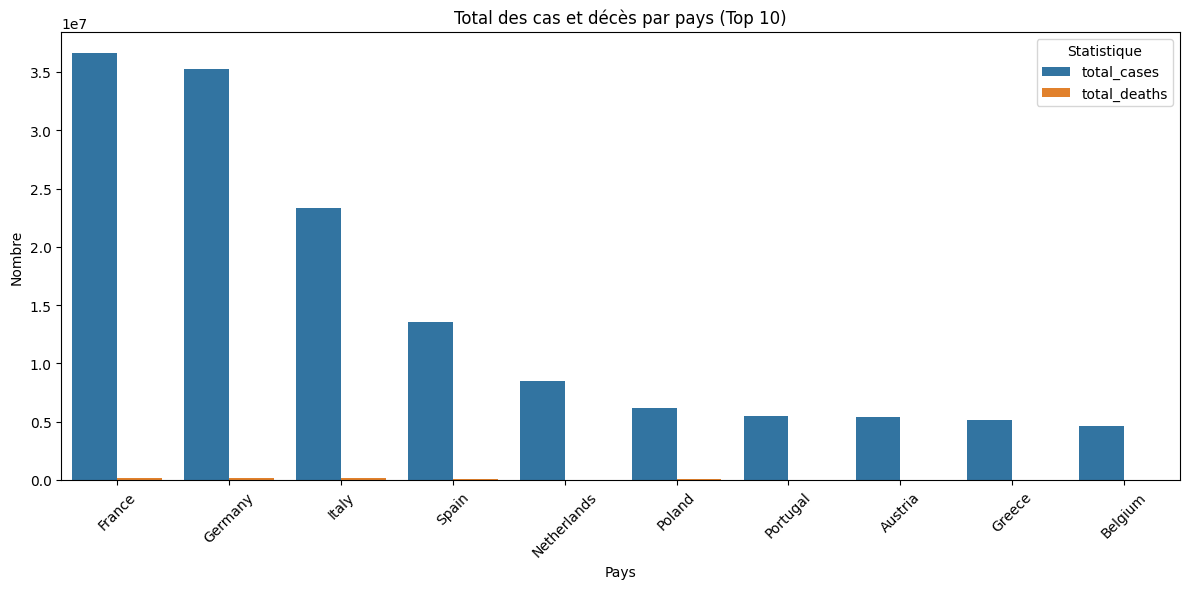

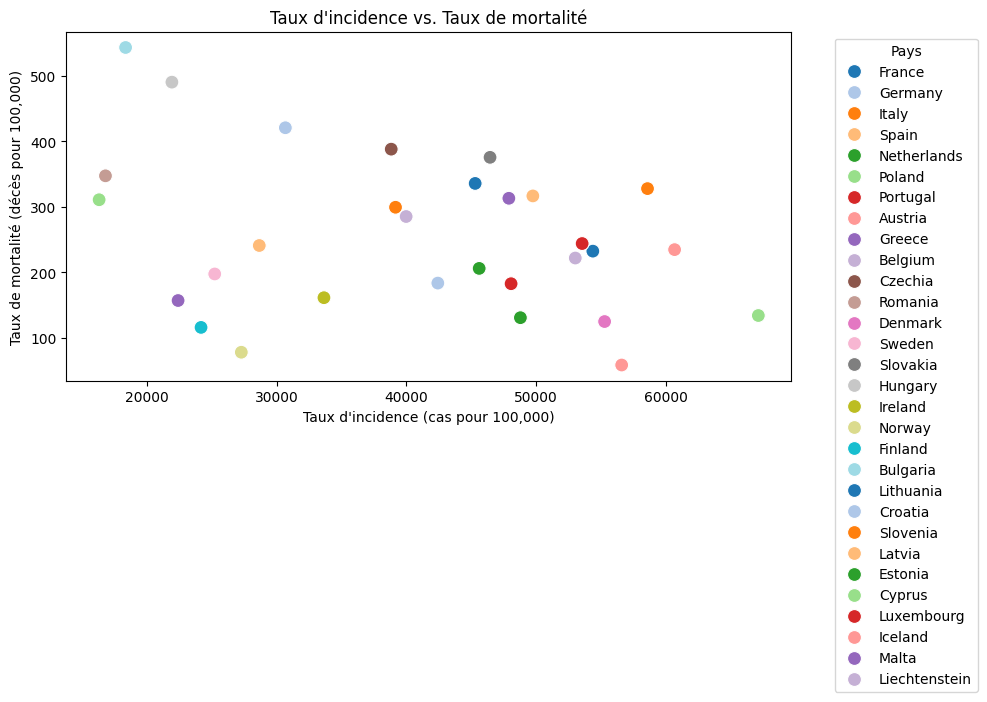

In [15]:
# Barplot des cas totaux et des décès par pays
plt.figure(figsize=(12, 6))
sns.barplot(
    data=country_stats.head(10).melt(id_vars='countriesAndTerritories', value_vars=['total_cases', 'total_deaths']),
    x='countriesAndTerritories', y='value', hue='variable'
)
plt.title("Total des cas et décès par pays (Top 10)")
plt.xlabel("Pays")
plt.ylabel("Nombre")
plt.xticks(rotation=45)
plt.legend(title="Statistique")
plt.tight_layout()
plt.show()

# Scatter plot des taux d'incidence et de mortalité
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=country_stats, x='incidence_rate', y='mortality_rate', hue='countriesAndTerritories', palette='tab20', s=100
)
plt.title("Taux d'incidence vs. Taux de mortalité")
plt.xlabel("Taux d'incidence (cas pour 100,000)")
plt.ylabel("Taux de mortalité (décès pour 100,000)")
plt.legend(title="Pays", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


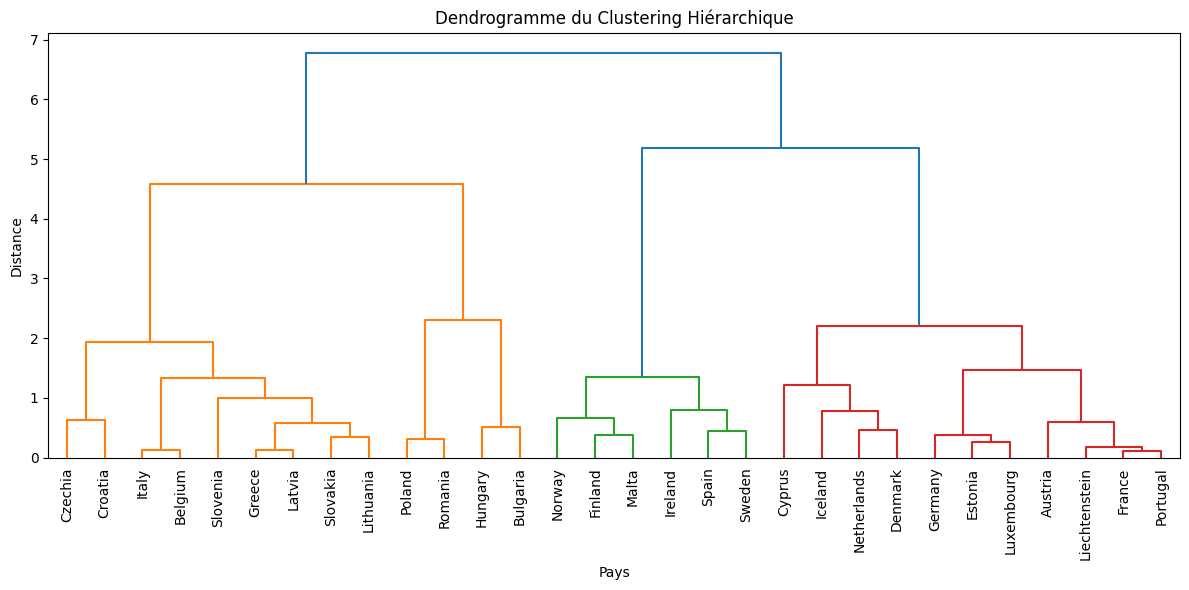


Pays et leurs clusters :
   countriesAndTerritories  cluster
26                Slovakia        1
18               Lithuania        1
16                  Latvia        1
3                  Croatia        1
5                  Czechia        1
1                  Belgium        1
11                  Greece        1
27                Slovenia        1
15                   Italy        1
23                  Poland        2
12                 Hungary        2
2                 Bulgaria        2
25                 Romania        2
28                   Spain        3
29                  Sweden        3
20                   Malta        3
14                 Ireland        3
22                  Norway        3
8                  Finland        3
4                   Cyprus        4
19              Luxembourg        4
13                 Iceland        4
7                  Estonia        4
9                   France        4
0                  Austria        4
24                Portugal        4
21

In [16]:
# Sélectionner les variables pour le clustering
data_for_clustering = country_stats[['incidence_rate', 'mortality_rate']]

# Normalisation des données
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_for_clustering)

# Clustering hiérarchique
linked = linkage(data_normalized, method='ward')

# Dendrogramme
plt.figure(figsize=(12, 6))
dendrogram(linked, labels=country_stats['countriesAndTerritories'].to_numpy(), leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogramme du Clustering Hiérarchique")
plt.xlabel("Pays")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# Découper l'arbre en clusters
n_clusters = 4  # Nombre de clusters (modifiable en fonction du dendrogramme)
clusters = fcluster(linked, n_clusters, criterion='maxclust')

# Ajouter les clusters au DataFrame
country_stats['cluster'] = clusters

# Afficher les résultats
print("\nPays et leurs clusters :")
print(country_stats[['countriesAndTerritories', 'cluster']].sort_values(by='cluster'))


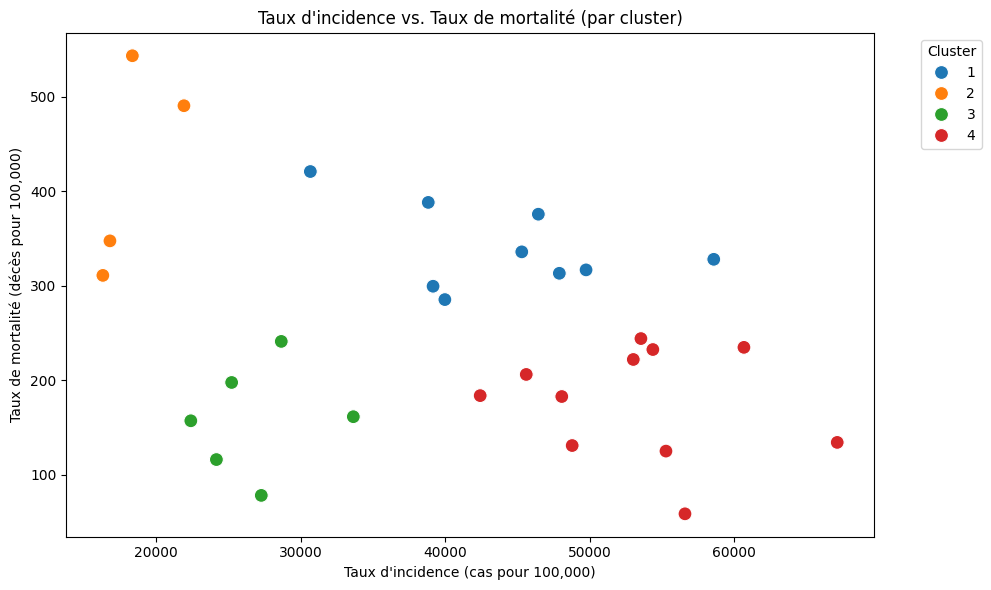

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7600\3462143481.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=country_stats, x='cluster', palette='tab10')


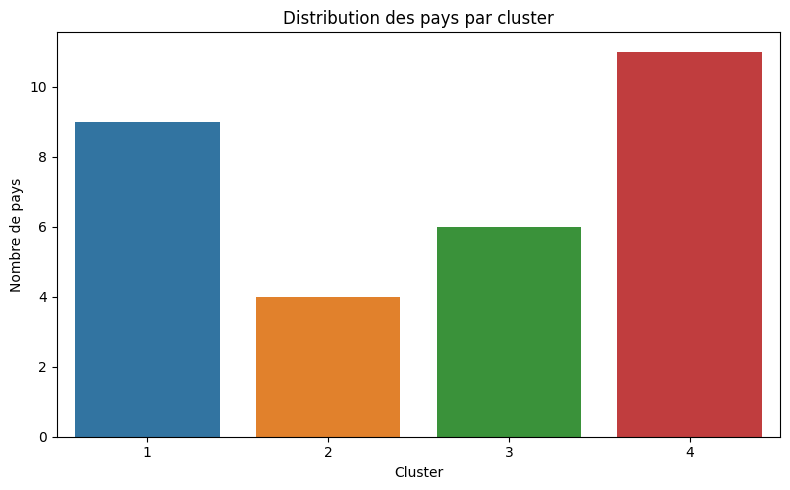

In [17]:
# Scatter plot des clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=country_stats,
    x='incidence_rate', y='mortality_rate',
    hue='cluster', palette='tab10', s=100
)
plt.title("Taux d'incidence vs. Taux de mortalité (par cluster)")
plt.xlabel("Taux d'incidence (cas pour 100,000)")
plt.ylabel("Taux de mortalité (décès pour 100,000)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Barplot de la distribution des clusters
plt.figure(figsize=(8, 5))
sns.countplot(data=country_stats, x='cluster', palette='tab10')
plt.title("Distribution des pays par cluster")
plt.xlabel("Cluster")
plt.ylabel("Nombre de pays")
plt.tight_layout()
plt.show()

In [18]:
# Liste des coordonnées géographiques des pays (latitude, longitude)
# Cette liste doit être complétée pour chaque pays concerné par le clustering
coordinates = {
    "Austria": [47.5162, 14.5501],
    "Belgium": [50.8503, 4.3517],
    "Bulgaria": [42.7339, 25.4858],
    "Croatia": [45.1, 15.2],
    "Cyprus": [35.1264, 33.4299],
    "Czechia": [49.8175, 15.4730],
    "Denmark": [56.2639, 9.5018],
    "Estonia": [58.5953, 25.0136],
    "Finland": [61.9241, 25.7482],
    "France": [46.6034, 1.8883],
    # Ajoutez d'autres pays et leurs coordonnées ici
}

# Créer une carte centrée sur l'Europe
m = folium.Map(location=[50, 10], zoom_start=4)

# Ajouter les pays avec les clusters sur la carte
for index, row in country_stats.iterrows():
    country = row['countriesAndTerritories']
    cluster = row['cluster']

    # Récupérer les coordonnées de chaque pays
    if country in coordinates:
        lat, lon = coordinates[country]

        # Définir la couleur en fonction du cluster
        cluster_colors = {1: 'blue', 2: 'green', 3: 'red', 4: 'purple'}
        color = cluster_colors.get(cluster, 'gray')

        # Ajouter un cercle sur la carte
        folium.CircleMarker(
            location=[lat, lon],
            radius=8,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6,
            popup=f"{country}: Cluster {cluster}"
        ).add_to(m)

# Afficher la carte
m.save("clusters_map.html")